converting the acouslic ai .mha files (combining the images, masks and circumference) into .npz files for faster processing during training time

In [ ]:
import os
import numpy as np
import pandas as pd
import SimpleITK as sitk
from tqdm import tqdm
import traceback

def load_ac_csv(csv_path):
    """Load abdominal circumference CSV as DataFrame with UUID as index."""
    df = pd.read_csv(csv_path).set_index("uuid")
    return df

def get_reference_ac(ac_df, uuid):
    """Get the first available sweep AC measurement for a given UUID."""
    try:
        ac_row = ac_df.loc[uuid]
        ac_values = ac_row.filter(like='sweep_').dropna().values
        return float(ac_values[0]) if len(ac_values) > 0 else None
    except Exception as e:
        print(f"⚠️ Error fetching AC for {uuid}: {e}")
        return None

def convert_acouslic_dataset(
    image_dir,
    mask_dir,
    csv_path,
    output_dir,
    limit=None,  # convert all if None
    pixel_spacing=0.28,
    add_channel_dim=False
):
    os.makedirs(output_dir, exist_ok=True)
    ac_df = load_ac_csv(csv_path)

    mha_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".mha")])
    converted = 0

    for f in tqdm(mha_files, desc="Converting ACOUSLIC cases"):
        if limit is not None and converted >= limit:
            break

        case_id = f.replace(".mha", "")
        uuid = case_id  # assumes filenames are UUIDs

        image_path = os.path.join(image_dir, f)
        mask_path = os.path.join(mask_dir, f)
        output_path = os.path.join(output_dir, f"{case_id}.npz")

        if os.path.exists(output_path):
            print(f"ℹ️ Skipping {case_id}: already exists.")
            continue

        try:
            # Load MHA image and mask
            img = sitk.ReadImage(image_path)
            mask = sitk.ReadImage(mask_path)

            img_np = sitk.GetArrayFromImage(img).astype(np.float32)   # [T, H, W]
            mask_np = sitk.GetArrayFromImage(mask).astype(np.uint8)   # [T, H, W]

            if img_np.shape != mask_np.shape:
                print(f"⚠️ Shape mismatch for {case_id}: image={img_np.shape}, mask={mask_np.shape}")
                continue

            # Normalize image to [0, 1]
            img_np -= img_np.min()
            img_np /= (img_np.max() + 1e-8)

            # Optional: Add channel dimension -> [T, 1, H, W]
            if add_channel_dim:
                img_np = img_np[:, np.newaxis, :, :]
                mask_np = mask_np[:, np.newaxis, :, :]

            # Binary classification label (per frame)
            label = ((mask_np > 0).any(axis=(1, 2))).astype(np.uint8)  # [T]
            if add_channel_dim:
                label = ((mask_np > 0).any(axis=(1, 2, 3))).astype(np.uint8)

            # Get ground-truth abdominal circumference
            ac_mm = get_reference_ac(ac_df, uuid)
            if ac_mm is None:
                print(f"⚠️ Missing AC value for {uuid}, skipping.")
                continue

            # Save to .npz
            np.savez_compressed(
                output_path,
                image=img_np.astype(np.float32),
                mask=mask_np.astype(np.uint8),
                label=label.astype(np.uint8),
                pixel_spacing=np.float32(pixel_spacing),
                ac_reference=np.float32(ac_mm),
                uuid=uuid
            )

            print(f"✅ Saved {case_id} | AC: {ac_mm:.2f} mm | Frames: {img_np.shape[0]}")
            converted += 1

        except Exception as e:
            print(f"❌ Error in {case_id}: {e}")
            traceback.print_exc()


In [ ]:
case = np.load("/kaggle/working/converted_npz/0199616b-bdeb-4119-97a3-a5a3571bd641.npz")
print(case.files)
print(case["image"].shape, case["mask"].shape, case["label"].shape)
print("Pixel spacing:", case["pixel_spacing"])
print("Ground-truth AC (mm):", case["ac_reference"])

case = np.load("/kaggle/working/converted_npz/02d3a9bc-63e2-4deb-9dc1-dba17e7d54c1.npz")
print(case.files)
print(case["image"].shape, case["mask"].shape, case["label"].shape)
print("Pixel spacing:", case["pixel_spacing"])
print("Ground-truth AC (mm):", case["ac_reference"])


Frames with positive label: 19 / 840


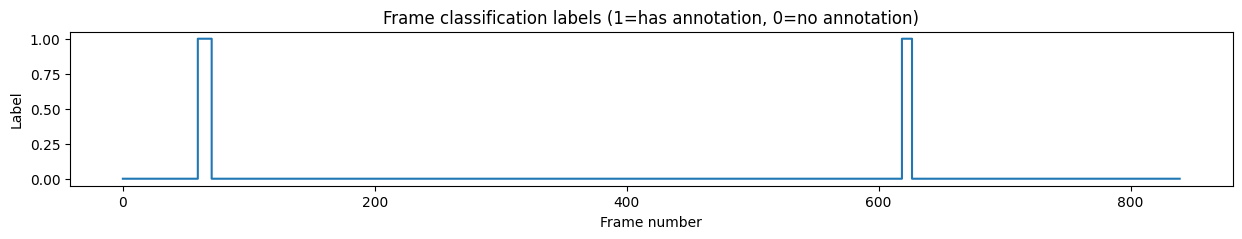

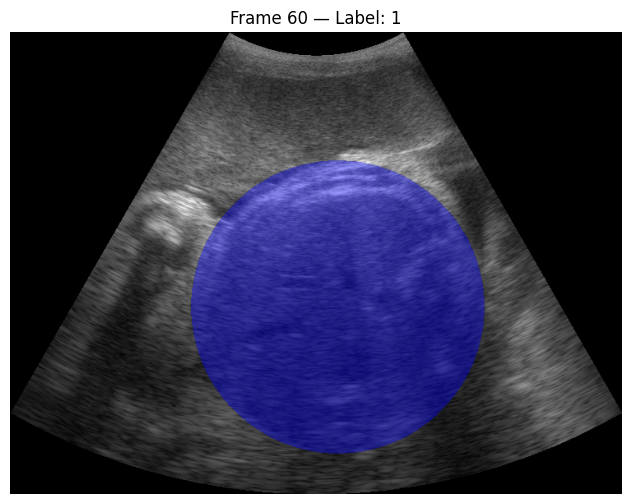

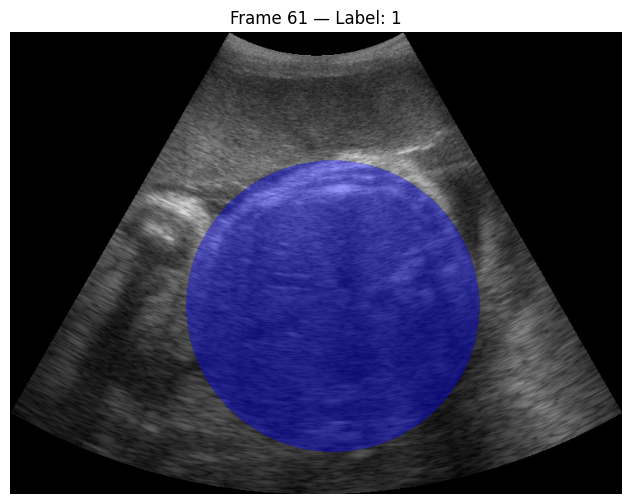

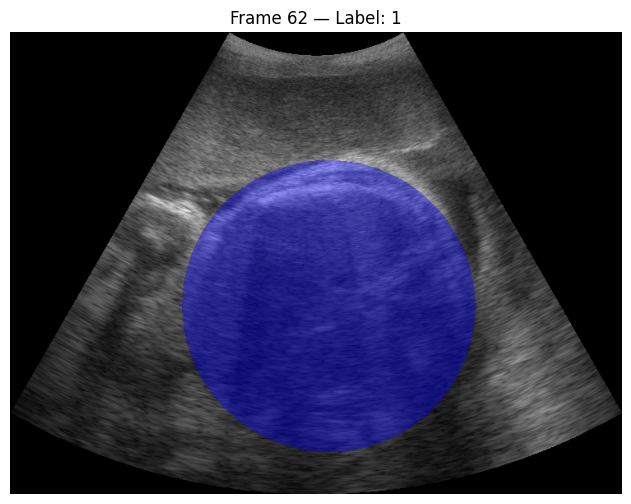

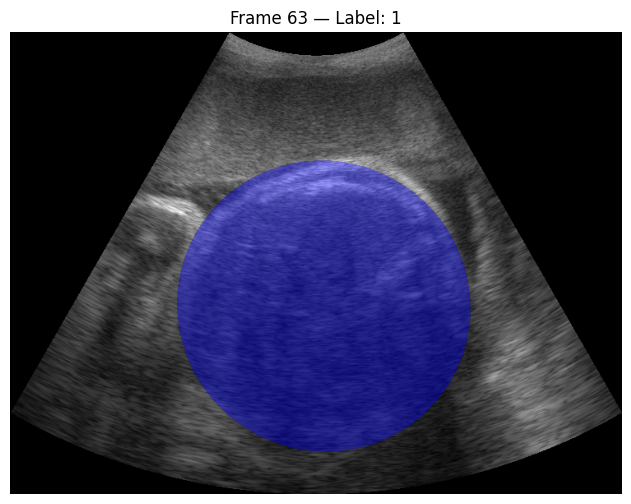

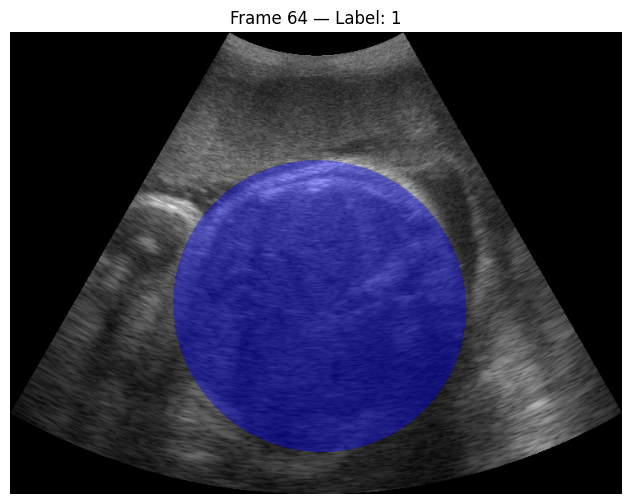

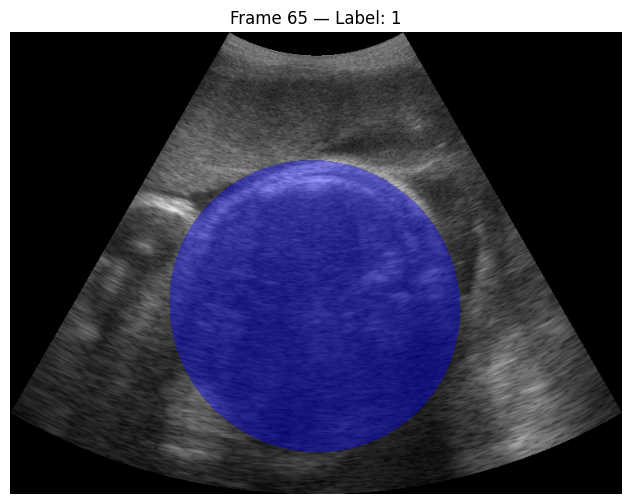

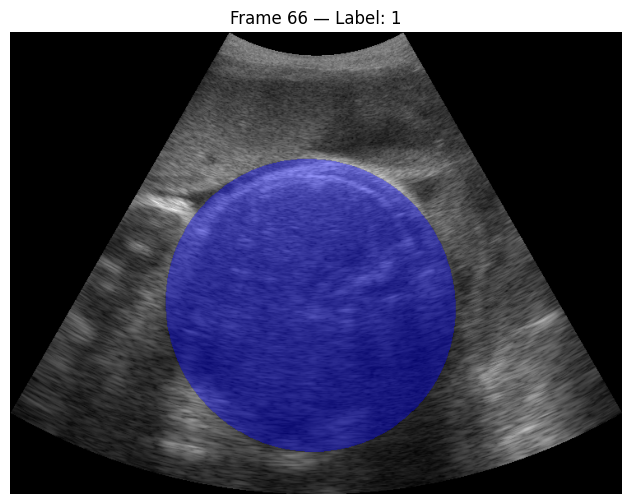

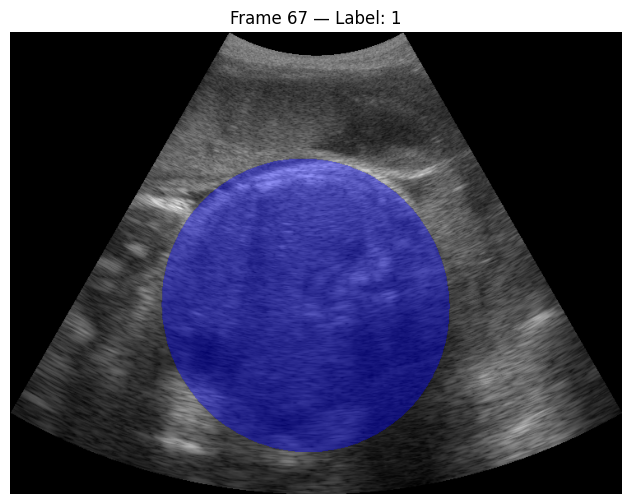

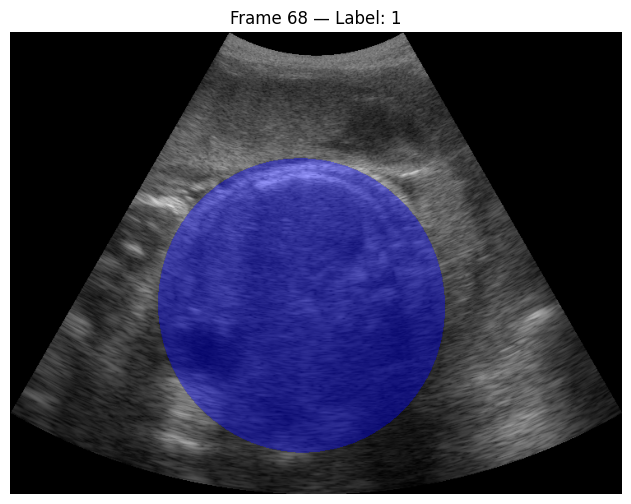

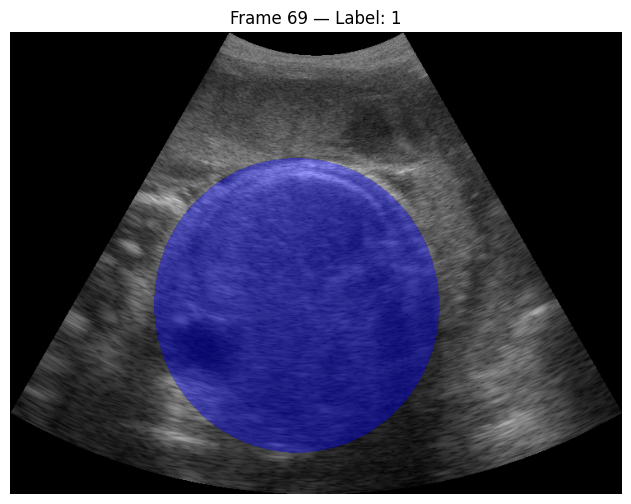

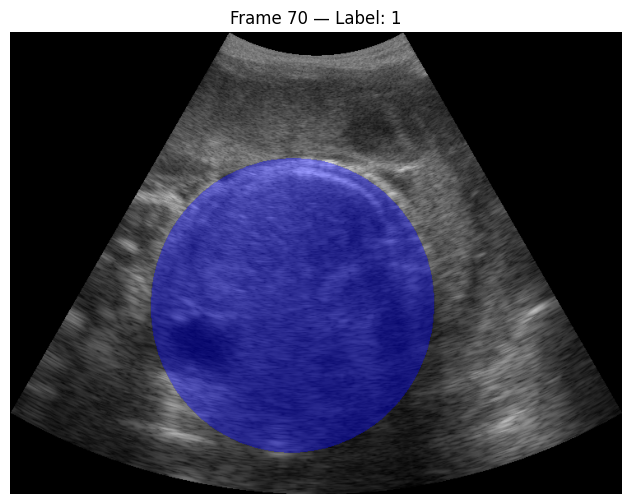

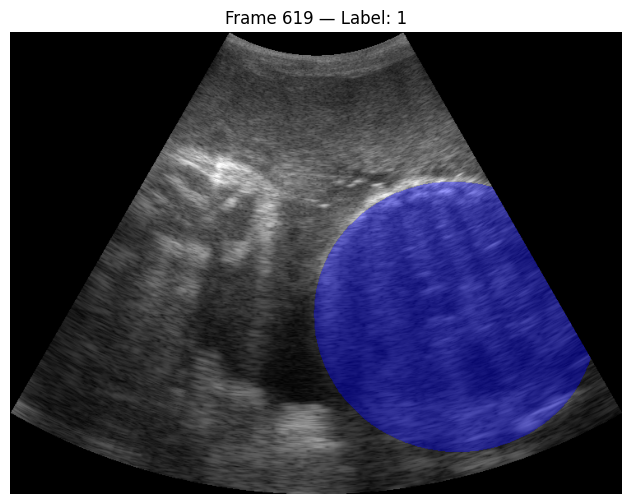

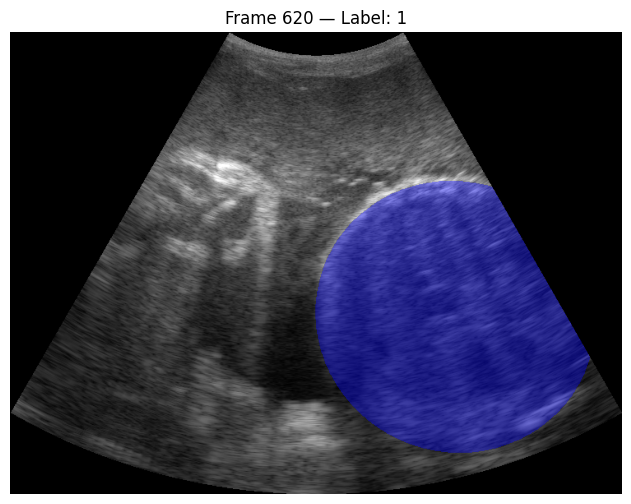

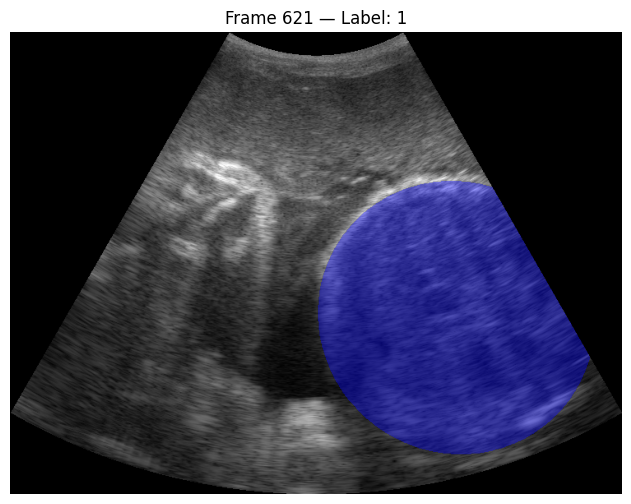

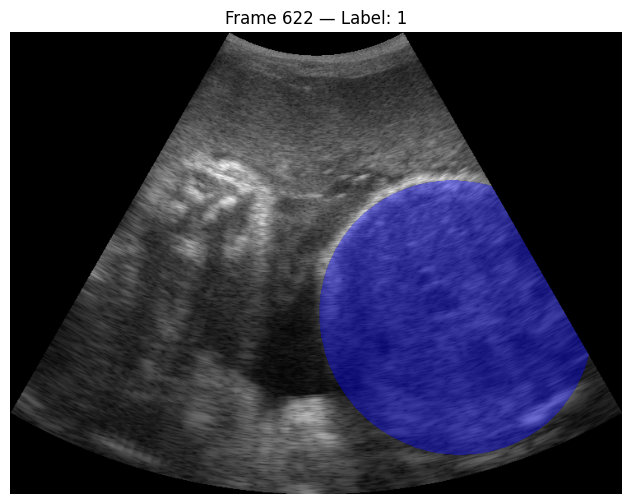

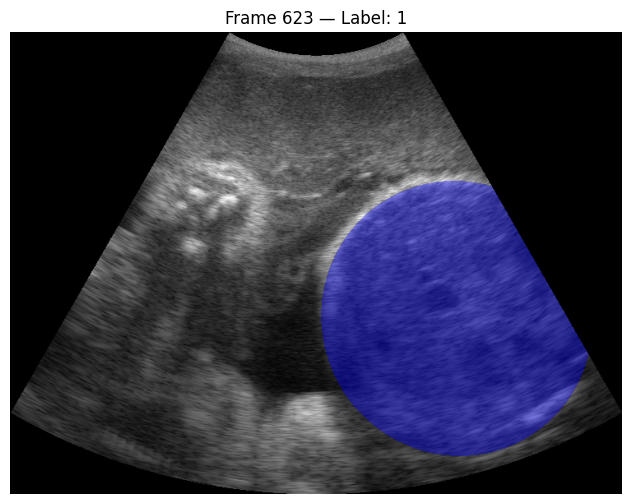

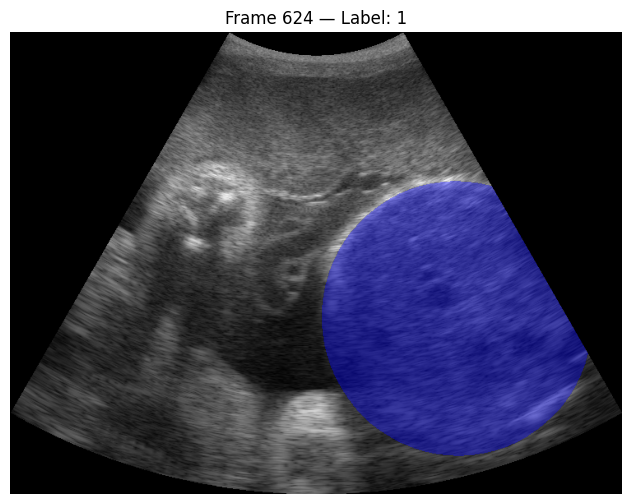

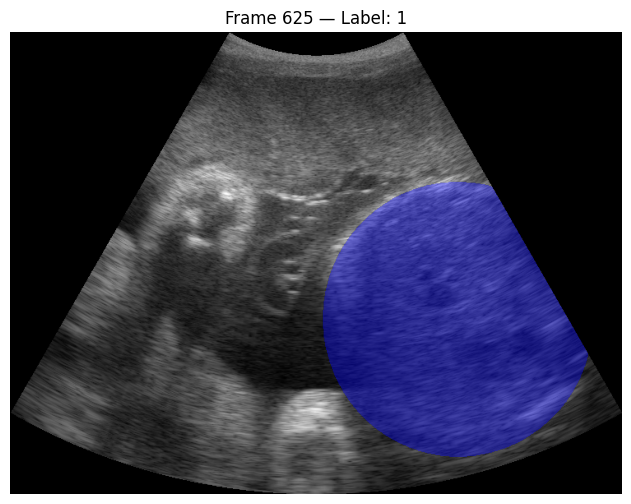

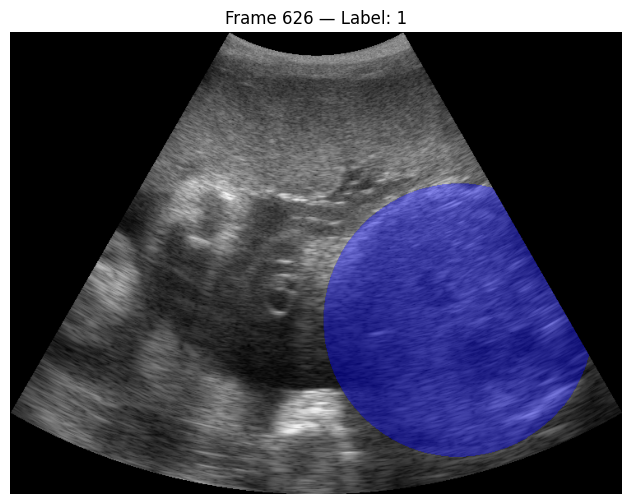

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Load your .npz file
case = np.load("G:/acouslic_mha_to_npz/0199616b-bdeb-4119-97a3-a5a3571bd641.npz")

images = case["image"]       # shape: (840, H, W)
masks = case["mask"]         # shape: (840, H, W)
labels = case["label"]       # shape: (840,)

print(f"Frames with positive label: {np.sum(labels)} / {len(labels)}")

# Plot classification labels as a timeline
plt.figure(figsize=(15, 2))
plt.title("Frame classification labels (1=has annotation, 0=no annotation)")
plt.plot(labels, drawstyle='steps-mid')
plt.xlabel("Frame number")
plt.ylabel("Label")
plt.show()

# Visualize a few example frames with segmentation masks overlayed
def show_frame_with_mask(frame_idx):
    img = images[frame_idx]
    mask = masks[frame_idx]

    plt.figure(figsize=(8, 6))
    plt.title(f"Frame {frame_idx} — Label: {labels[frame_idx]}")
    plt.imshow(img, cmap='gray')
    # Overlay mask with transparency; use colors for mask values 1 and 2
    # Create colored mask overlay
    mask_overlay = np.zeros((*mask.shape, 4))  # RGBA

    # Optimal mask (1) - Red with alpha
    mask_overlay[mask == 1] = [1, 0, 0, 0.4]
    # Suboptimal mask (2) - Blue with alpha
    mask_overlay[mask == 2] = [0, 0, 1, 0.4]

    plt.imshow(mask_overlay)
    plt.axis("off")
    plt.show()

# Show first 3 frames that have annotations
annotated_frames = np.where(labels == 1)[0]
for idx in annotated_frames[:50]:
    show_frame_with_mask(idx)
